# Model training

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import time

import data_reader
import dataset
from plots import learning_curve_train

In [2]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [3]:
# Training and data variables

MODE = "w"
EXP_NAME = "tcia_effnet"

DATA_SET_NAME = f"tcia_data_set_SPLIT" #"data_set_X20_100%_SPLIT"
PATCH_SIZE = 512

BATCH_SIZE = 16
EPOCHS = 25

SIZE_X = PATCH_SIZE
SIZE_Y = PATCH_SIZE

#threshold = 0.05 # Loss difference for early stopping

In [4]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init():
    global net, loss_function, scheduler, optimizer, MODEL_NAME

    #net = torchvision.models.resnet18(pretrained=True).to(device)
    net = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True).to(device)
    
    #print(f"Loading {MODEL_NAME}")
    #net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading
    
    for param in net.parameters():
        param.requires_grad = False # Freezing the convolutional layers 

    net.fc = nn.Sequential(
                #nn.Dropout(p=0.5),  
                #nn.Linear(512, 2),
                nn.Linear(1000,2),
                #nn.ReLU(inplace=True),
                #nn.Linear(128, 3),
                nn.Softmax(dim = -1)
                ).to(device)

    for param in net.fc.parameters():
        param.requires_grad = True
    print(net)

    #for param in net.layer3.parameters():
    #    param.requires_grad = True
    
    #for param in net.layer4[1].parameters():
    #    param.requires_grad = True # Unfreezing the last residual block

    net.fc.apply(init_weights) # Xavier init

    n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.layer4[1].parameters())
    print("Number of free parameters: ", n_params)

    #Hyperparameters:
    learning_rate = 1E-4 # LR
    loss_function = nn.CrossEntropyLoss()  # Loss
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)# Optimizer
    lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


In [5]:
def fwd_pass(X, y, train=False):
# IMPORTANTE, TRAIN = FALSE PARA QUE NO ENTRENE CON EL TEST DATA ESTO ES PARA PODER HACER TEST MIENTRAS ENTRENO Y VALIDO, 
# SE ESPERA QUE LA EXACTITUD EN EL TEST DE VALIDACIÓN SEA MENOR
    if train: 
        net.zero_grad()
        
    # NORMALIZATION
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = torchvision.transforms.Normalize(mean=mean, std=std)

    for i, x in enumerate(X):
        X[i] = normalize(X[i]/255) # Np array

    outputs = net(X)
    
    y_pred = [torch.argmax(i) for i in outputs.cpu()]
    y_true = [torch.argmax(i) for i in y.cpu()]

    #acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)
    conf_m = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    auc = 0 #sklearn.metrics.roc_auc_score(y_true, y_pred, average= "micro", multi_class="ovr") #!!!!

    if train:
        loss.backward() # Calculate gradients using backprop
        optimizer.step() # Updates W and b using previously calculated gradients

    return [acc, loss, conf_m, f1, auc]

In [6]:
def train():
  global net, loss_function, scheduler, optimizer, train_set, val_set, MODEL_NAME, EPOCHS
  
  print(MODEL_NAME)
  patience = 0

  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1, auc = 0, 0, 0, 0
      val_acc, val_loss, val_f1, val_auc = 0, 0, 0, 0
      conf_m, val_conf_m = np.zeros((2,2)), np.zeros((2,2))

      print("\nEPOCH: ", epoch+1)

      n_patches = sum(len(batch[0]) for batch in iter(train_dataloader))

      for batch_X, batch_y in tqdm(iter(train_dataloader)):
         # Number of patches in dataloader
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0,3,2,1), batch_y.type(torch.FloatTensor).to(device) 
        
        net.train() # Making sure that the model is in training mode
        
        performance_metrics = fwd_pass(batch_X, batch_y, train=True)
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]
        acc += acc_aux*(len(batch_X)/n_patches) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        loss += loss_aux*(len(batch_X)/n_patches)
        conf_m += conf_m_aux
        f1 += f1_aux*(len(batch_X)/n_patches)
        auc += auc_aux*(len(batch_X)/n_patches)

      for batch_X, batch_y in tqdm(iter(val_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

        net.eval() # Making sure that the model is not training and deactivate droptout
        
        with torch.no_grad(): # Disable all computations, works together with net.eval()
          performance_metrics = fwd_pass(batch_X, batch_y, train=False)
          
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]  
        val_acc += acc_aux*(len(batch_X)/len(val_set)) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        val_loss += loss_aux*(len(batch_X)/len(val_set))
        val_conf_m += conf_m_aux
        val_f1 += f1_aux*(len(batch_X)/len(val_set))
        val_auc += auc_aux*(len(batch_X)/len(val_set))
        
      print("Val loss: ", val_loss.item(), " Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc, " Train acc: ", acc, "\n")
      print("Val AUC: ", val_auc, " Train AUC: ", auc)
      print("Val f1: ", val_f1, " Train f1: ", f1, "\n")
      print("Val CONF: \n", val_conf_m, "\nTrain CONF: \n", conf_m, "\n")

      conf_m = f"{conf_m[0][0]}+{conf_m[0][1]}+{conf_m[1][0]}+{conf_m[1][1]}"
      val_conf_m = f"{val_conf_m[0][0]}+{val_conf_m[0][1]}+{val_conf_m[1][0]}+{val_conf_m[1][1]}"
    
      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{conf_m},{round(float(auc),4)},")
      f.write(f"{round(float(val_acc),3)},{round(float(val_loss),4)},{val_conf_m}, {round(float(val_auc),4)}\n")
      f.write("\n\n")

      # Early stopping, if the difference between loss and validation loss 
      # is bigger than the threshold for 3 epochs in a row training is stopped
      if val_loss.item()>loss.item():#> threshold:
        patience +=1
      else:
        patience = 0

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

      if patience >= 7:
        print("Stopping early: ")
        break

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")

In [7]:
# Choosing only the images from the according splits (10CV)

SPLITS = [0]#,5,6,7,8,9] # Number of iterations > n_splits
n_splits = 10 # Number of splits to use

for SPLIT in SPLITS:
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    TRAIN_SPLITS = list(range(n_splits))
    # We take out the SPLIT and SPLIT+1 sets for val and testing
    if SPLIT == n_splits-1: # For the final split for validation we take the firs one for test
        TRAIN_SPLITS.remove(0) 
    else:
        TRAIN_SPLITS.remove(SPLIT+1)
    TRAIN_SPLITS.remove(SPLIT)

    train_set = dataset.PatchDataset([], [], [])
    val_set = dataset.PatchDataset([], [], [])
    test_set = dataset.PatchDataset([], [], [])

    # Loading training splits:
    for i in TRAIN_SPLITS:
        print(f"Loading training split: {i}")
        SPLIT_NAME = DATA_SET_NAME + f"{i}"
        
        X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/patches/{SPLIT_NAME}")

        train_set.inputs.extend(X_)
        train_set.labels.extend(y_)
        train_set.case_ids.extend(patch_ids_)

    # Random oversampler
    negative =  [i[0] for i in train_set.labels]
    positive =  [i[1] for i in train_set.labels]

    class_sample_count = np.array([sum(negative), sum(positive)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[np.argmax(t)] for t in train_set.labels])
    samples_weight = torch.from_numpy(samples_weight) # Probability for a sample to be sampled
    #samples_weight = torch.tensor([1/len(samples_weight)]*len(samples_weight))
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), 2*int(sum(negative)))#, replacement=False) #int(len(train_set)))#
    # Will take len(samples_weight) number of samples, this can be changed

    # Creating DataLoader
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    
    print(f"Patches for training: {len(train_set)}\n")
    
    # Loading validation splits:
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    print(f"Loading validation split: {SPLIT}")

    X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/patches/{SPLIT_NAME}")

    val_set.inputs.extend(X_)
    val_set.labels.extend(y_)
    val_set.case_ids.extend(patch_ids_)

    val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for validation: {len(val_set)}\n")

    init()

    train()

    del train_set, val_set, test_set


Loading training split: 2
Read lmdb


tcia_25ep0


c:\Users\Alejandro\Desktop\heterogeneous-data\src\WSI\plots.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


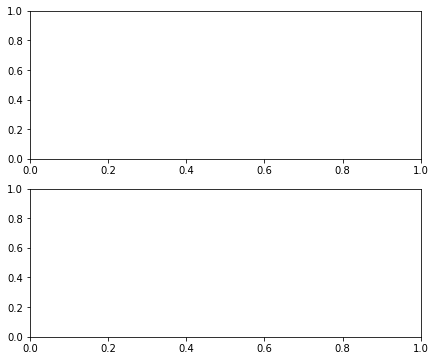

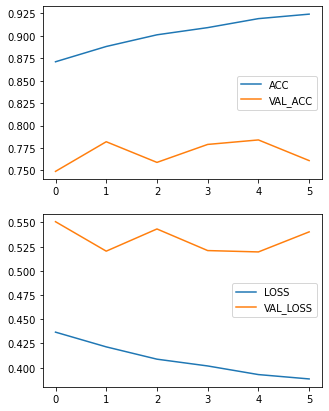

In [ ]:
for SPLIT in range(1):
    NAME = EXP_NAME + f"{SPLIT}"
    print(NAME)
    learning_curve_train(NAME)